In [1]:
from typing import List, TypedDict
import time
import os

from langchain_community.document_loaders import PyPDFLoader
from langchain_community.vectorstores import FAISS
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_groq import ChatGroq
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_core.documents import Document
from langchain_core.prompts import ChatPromptTemplate

from langgraph.graph import START, StateGraph, END

from dotenv import load_dotenv
load_dotenv()

True

In [2]:
embeddings=HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")

C:\Users\004NQ8744\OneDrive\Roadwork\langChain\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
groq_api_key = os.getenv("GROQ_API_KEY")
# llm=ChatGroq(groq_api_key=groq_api_key,model_name="Gemma2-9b-It")
llm = ChatGroq(groq_api_key=groq_api_key, model_name="llama-3.1-8b-instant")

In [4]:
docs = (
    PyPDFLoader("./documents/book1.pdf").load() +
    PyPDFLoader("./documents/book2.pdf").load()
)


In [5]:
len(docs)

1559

In [6]:
chunks = RecursiveCharacterTextSplitter(chunk_size=900, chunk_overlap=150).split_documents(docs)

Clean text to avoid UnicodeEncodeError (surrogates from PDF extraction)

In [7]:
for chunk in chunks:
    chunk.page_content = chunk.page_content.encode("utf-8", "ignore").decode("utf-8", "ignore")

In [8]:
len(chunks)

5033

In [9]:
vector_store = FAISS.from_documents(chunks, embeddings)

In [10]:
retriever = vector_store.as_retriever(search_type="similarity", search_kwargs={'k':4})

In [11]:
class State(TypedDict):
    question: str
    docs: List[Document]
    answer: str

In [12]:
def retrieve(state):
    q = state["question"]
    return {"docs": retriever.invoke(q)}

In [13]:
prompt = ChatPromptTemplate.from_messages(
    [
        ("system", "Answer only from the context. If not in context, say you don't know."),
        ("human", "Question: {question}\n\nContext:\n{context}"),
    ]
)

In [14]:
def generate(state):
    context = "\n\n".join(doc.page_content for doc in state["docs"])
    output = (prompt | llm).invoke({"question": state["question"], "context": context})
    return {"answer": output.content}

In [15]:
g = StateGraph(State)
g.add_node("retrieve", retrieve)
g.add_node("generate", generate)
g.add_edge(START, "retrieve")
g.add_edge("retrieve", "generate")
g.add_edge("generate", END)

app = g.compile()

In [16]:
app

CompiledStateGraph(nodes={'__start__': PregelNode(config={'tags': ['langsmith:hidden']}, channels=['__start__'], triggers=['__start__'], writers=[ChannelWrite<question,docs,answer>(recurse=True, writes=[ChannelWriteEntry(channel='question', value=<object object at 0x000001D9691B4D10>, skip_none=False, mapper=_get_state_key(recurse=False)), ChannelWriteEntry(channel='docs', value=<object object at 0x000001D9691B4D10>, skip_none=False, mapper=_get_state_key(recurse=False)), ChannelWriteEntry(channel='answer', value=<object object at 0x000001D9691B4D10>, skip_none=False, mapper=_get_state_key(recurse=False))]), ChannelWrite<start:retrieve>(recurse=True, writes=[ChannelWriteEntry(channel='start:retrieve', value='__start__', skip_none=False, mapper=None)])]), 'retrieve': PregelNode(config={'tags': []}, channels={'question': 'question', 'docs': 'docs', 'answer': 'answer'}, triggers=['start:retrieve'], mapper=functools.partial(<function _coerce_state at 0x000001D96AA131A0>, <class '__main__.S

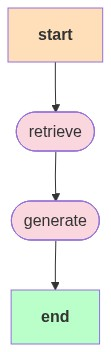

In [17]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [23]:
res = app.invoke({"question": "WHat is a transformer in deep learning.", "docs": [], "answer": ""})
print(res["answer"])

I don't know the context of the term "transformer" in deep learning from the given text. However, in the broader context of deep learning, a transformer is a type of neural network architecture that was introduced in the paper "Attention is All You Need" by Vaswani et al. in 2017. It is particularly well-suited for tasks that involve sequential data, such as natural language processing and machine translation. The transformer architecture is designed to handle variable-length input sequences without relying on recurrent neural networks (RNNs) or convolutional neural networks (CNNs).


In [24]:
res = app.invoke({"question": "What is deep learning.", "docs": [], "answer": ""})
print(res["answer"])

Deep learning is a field of neural networks that has undergone many changes in name and popularity over time, dating back to the 1940s. It is a technology that has become increasingly useful as the amount of available training data has increased, and has grown in size as computer infrastructure has improved.


Retrieval Refinement

In [18]:
import re
from pydantic import BaseModel

In [19]:
class State(TypedDict):
    question: str
    docs: List[Document]

    strips: List[str]
    kept_strips: List[str]
    refined_context: str

    answer: str

In [20]:
def retrieve(state):
    q = state["question"]
    return {"docs": retriever.invoke(q)}

Sentence level decomposer

In [21]:
def decompose_to_sentences(text: str) -> List[str]:
    text = re.sub(r"\s+", " ", text).strip()
    sentences = re.split(r"(?<=[.!?])\s+", text)
    return [s.strip() for s in sentences if len(s.strip())>20]

In [25]:
print(res["answer"])

Deep learning is a field of neural networks that has undergone many changes in name and popularity over time, dating back to the 1940s. It is a technology that has become increasingly useful as the amount of available training data has increased, and has grown in size as computer infrastructure has improved.


In [33]:
decompose_to_sentences(res["answer"])

['Deep learning is a type of artificial neural network that represents functions of increasing complexity by adding more layers and more units within a layer.',
 'It is a powerful framework for supervised learning and has a long history, dating back to the 1940s, although it has undergone several name changes and periods of increased and decreased popularity over the years.']

In [34]:
len(decompose_to_sentences(res["answer"]))

2

Filter (LLM Judge)

In [26]:
class KeepOrDrop(BaseModel):
    keep: bool

In [27]:
filter_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a strict relevance filter.\n"
            "Return keep=true only if the sentence directly helps answer the question.\n"
            "Use ONLY the sentence. Output JSON only.",
        ),
        ("human", "Question: {question}\n\nSentence:\n{sentence}"),
    ]
)

In [28]:
filter_chain = filter_prompt | llm.with_structured_output(KeepOrDrop)

Refining (Decompose=> Filter => Recompose)

In [29]:
def refine(state):
    q = state["question"]
    context = "\n\n".join(d.page_content for d in state["docs"]).strip()
    strips = decompose_to_sentences(context)
    kept: List[str] = []
    for s in strips:
        if filter_chain.invoke({"question": q, "sentence": s})["keep"]:
            kept.append(s)
    refined_context = "/n".join(kept).strip()
    return {
        "strips": strips,
        "kept": kept,
        "refined_context": refined_context
    }

In [30]:
answer_prompt = ChatPromptTemplate.from_messages([
    (
            "system",
            "You are a helpful ML tutor. Answer ONLY using the provided refined bullets.\n"
            "If the bullets are empty or insufficient, say: 'I don't know based on the provided docs.'",
        ),
        ("human", "Question: {question}\n\nRefined context:\n{refined_context}"),
])

In [31]:
def generate(state):
    output = (answer_prompt | llm).invoke({"question": state["question"], "refined_context": state["refined_context"]})
    return {"answer": output.content}

In [32]:
g = StateGraph(State)
g.add_node("retrieve", retrieve)
g.add_node("refine", refine)
g.add_node("generate", generate)

g.add_edge(START, "retrieve")
g.add_edge("retrieve", "refine")
g.add_edge("refine", "generate")
g.add_edge("generate", END)

app = g.compile()
app

CompiledStateGraph(nodes={'__start__': PregelNode(config={'tags': ['langsmith:hidden']}, channels=['__start__'], triggers=['__start__'], writers=[ChannelWrite<question,docs,strips,kept_strips,refined_context,answer>(recurse=True, writes=[ChannelWriteEntry(channel='question', value=<object object at 0x000001D9691B4D10>, skip_none=False, mapper=_get_state_key(recurse=False)), ChannelWriteEntry(channel='docs', value=<object object at 0x000001D9691B4D10>, skip_none=False, mapper=_get_state_key(recurse=False)), ChannelWriteEntry(channel='strips', value=<object object at 0x000001D9691B4D10>, skip_none=False, mapper=_get_state_key(recurse=False)), ChannelWriteEntry(channel='kept_strips', value=<object object at 0x000001D9691B4D10>, skip_none=False, mapper=_get_state_key(recurse=False)), ChannelWriteEntry(channel='refined_context', value=<object object at 0x000001D9691B4D10>, skip_none=False, mapper=_get_state_key(recurse=False)), ChannelWriteEntry(channel='answer', value=<object object at 0x0

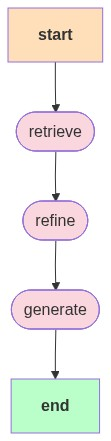

In [33]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [52]:
res = app.invoke({
    "question": "Explain the bias–variance tradeoff",
    "docs": [],
    "strips": [],
    "kept_strips": [],
    "refined_context": "",
    "answer": ""
})
print(res["answer"])

* The bias–variance tradeoff is the idea that there is a balance between model bias and variance.
* Model bias measures how far off a model's expected output is from the true output.
* Model variance measures how much the model's output varies across different training sets.
* Increasing model complexity (e.g., decreasing the regularization coefficient λ) reduces bias but increases variance.
* Decreasing model complexity (e.g., increasing the regularization coefficient λ) reduces variance but increases bias.
* The goal is to find a balance between bias and variance to minimize the expected loss.


In [53]:
print(res['docs'][0].page_content)
print('*'*100)
print(res['docs'][1].page_content)
print('*'*100)
print(res['docs'][2].page_content)
print('*'*100)
print(res['docs'][3].page_content)

3.2. The Bias-Variance Decomposition 151
Figure 3.6 Plot of squared bias and variance,
together with their sum, correspond-
ing to the results shown in Fig-
ure 3.5. Also shown is the average
test set error for a test data set size
of 1000 points. The minimum value
of (bias)2 + variance occurs around
ln λ = −0.31, which is close to the
value that gives the minimum error
on the test data.
lnλ
−3 −2 −1 0 1 2
0
0.03
0.06
0.09
0.12
0.15
(bias)2
variance
(bias)2 + variance
test error
ﬁt a model with 24 Gaussian basis functions by minimizing the regularized error
function (3.27) to give a prediction function y(l)(x) as shown in Figure 3.5. The
top row corresponds to a large value of the regularization coefﬁcientλ that gives low
variance (because the red curves in the left plot look similar) but high bias (because
****************************************************************************************************
with respect to multiple data sets.
We can also examine the bias-variance trade-

In [54]:
res["refined_context"]

'The top row corresponds to a large value of the regularization coefﬁcientλ that gives low variance (because the red curves in the left plot look similar) but high bias (because with respect to multiple data sets./nWe see that small values of λ allow the model to become ﬁnely tuned to the noise on each individual and the bias and variance terms now refer to integrated quantities./nOur goal is to minimize the expected loss, which we have decomposed into the sum of a (squared) bias, a variance, and a constant noise term.'

In [84]:
fail = app.invoke({
    "question": "Explain the latest AI news",
    "docs": [],
    "strips": [],
    "kept_strips": [],
    "refined_context": "",
    "answer": ""
})
print(fail["answer"])

I don't know based on the provided docs.


Retrieval Evaluator

In [34]:
UPPER_TH = 0.7
LOWER_TH = 0.3

In [35]:
class State(TypedDict):
    question: str
    docs: List[Document]

    good_docs: List[Document]
    verdict: str
    reason: str

    strips: List[str]
    kept_strips: List[str]
    refined_context: str

    answer: str

In [37]:
def retrieve(state):
    q = state["question"]
    return {"docs": retriever.invoke(q)}

Score based doc evaluator

In [38]:
class DocEvalScore(BaseModel):
    score: float
    reason: str

In [39]:
doc_eval_prompt = ChatPromptTemplate.from_messages([
    (
            "system",
            "You are a strict retrieval evaluator for RAG.\n"
            "You will be given ONE retrieved chunk and a question.\n"
            "Return a relevance score in [0.0, 1.0].\n"
            "- 1.0: chunk alone is sufficient to answer fully/mostly\n"
            "- 0.0: chunk is irrelevant\n"
            "Be conservative with high scores.\n"
            "Also return a short reason.\n"
            "Output JSON only.",
        ),
        ("human", "Question: {question}\n\nChunk:\n{chunk}"),
])

In [40]:
doc_eval_chain = doc_eval_prompt | llm.with_structured_output(DocEvalScore)

In [65]:
def eval_each_doc(state):
    q = state["question"]
    scores = []
    good = []
    for d in state["docs"]:
        out = doc_eval_chain.invoke({"question": q, "chunk": d.page_content})
        scores.append(out["score"])
        if out["score"] > LOWER_TH:
            good.append(d)
    
    if any(s > UPPER_TH for s in scores):
        return {
            "good_docs": good,
            "verdict": "CORRECT",
            "reason": f"At least one retrieved chunk scored > {UPPER_TH}"
        }
    if len(scores)>0 and all(s < LOWER_TH for s in scores):
        return {
            "good_docs": [],
            "verdict": "INCORRECT",
            "reason": f"All retrieved chunks scored < {LOWER_TH}. No chunk was sufficient to answer the query"
        }
    return {
        "good_docs": good,
        "verdict": "AMBIGUOUS",
        "reason": f"Chunks scored between {LOWER_TH} and {UPPER_TH}. Mixed relevance signals"
    }

In [66]:
def decompose_to_sentences(text: str) -> List[str]:
    text = re.sub(r"\s+", " ", text).strip()
    sentences = re.split(r"(?<=[.!?])\s+", text)
    return [s.strip() for s in sentences if len(s.strip())>20]

In [67]:
class KeepOrDrop(BaseModel):
    keep: bool

In [68]:
filter_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a strict relevance filter.\n"
            "Return keep=true only if the sentence directly helps answer the question.\n"
            "Use ONLY the sentence. Output JSON only.",
        ),
        ("human", "Question: {question}\n\nSentence:\n{sentence}"),
    ]
)

In [69]:
filter_chain = filter_prompt | llm.with_structured_output(KeepOrDrop)

In [70]:
def refine(state):
    q = state["question"]
    context = "\n\n".join(d.page_content for d in state["good_docs"]).strip()
    strips = decompose_to_sentences(context)
    kept: List[str] = []
    for s in strips:
        if filter_chain.invoke({"question": q, "sentence": s})["keep"]:
            kept.append(s)
    refined_context = "/n".join(kept).strip()
    return {
        "strips": strips,
        "kept": kept,
        "refined_context": refined_context
    }


In [71]:
answer_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a helpful ML tutor. Answer ONLY using the provided context.\n"
            "If the context is empty or insufficient, say: 'I don't know.'",
        ),
        ("human", "Question: {question}\n\nRefined context:\n{refined_context}"),
    ]
)

In [72]:
def generate(state):
    out = (answer_prompt | llm).invoke(
        {"question": state["question"], "refined_context": state["refined_context"]}
    )
    return {"answer": out.content}

In [73]:
def fail_node(state):
    return {"answer": f"FAIL: {state['reason']}"}

In [74]:
def ambiguous_node(state):
    return {"answer": f"AMBIGUOUS: {state['reason']}"}

In [75]:
def route_after_eval(state):
    if state["verdict"]=="CORRECT":
        return "refine"
    elif state["verdict"]=="INCORRECT":
        return "websearch"
    else:
        return "ambiguous"

In [76]:
g = StateGraph(State)
g.add_node("retrieve", retrieve)
g.add_node("eval_each_doc", eval_each_doc)
g.add_node("refine", refine)
g.add_node("generate", generate)
g.add_node("fail", fail_node)
g.add_node("ambiguous", ambiguous_node)

g.add_edge(START, "retrieve")
g.add_edge("retrieve", "eval_each_doc")

g.add_conditional_edges(
    "eval_each_doc",
    route_after_eval,
    {"refine": "refine", "web_search": "fail", "ambiguous": "ambiguous"}
)
g.add_edge("refine", "generate")
g.add_edge("generate", END)
g.add_edge("fail", END)
g.add_edge("ambiguous", END)

app = g.compile()

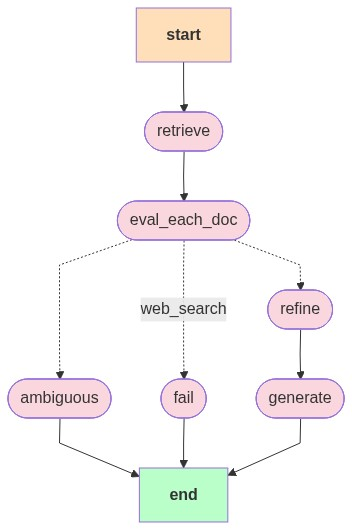

In [77]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [78]:
res = app.invoke(
    {
        "question": "What are attention mechanisms and why are they important in current models?",
        "docs": [],
        "good_docs": [],
        "verdict": "",
        "reason": "",
        "strips": [],
        "kept_strips": [],
        "refined_context": "",
        "answer": "",
    }
)

print("VERDICT:", res["verdict"])
print("REASON:", res["reason"])
print("\nOUTPUT:\n", res["answer"])

VERDICT: AMBIGUOUS
REASON: Chunks scored between 0.3 and 0.7. Mixed relevance signals

OUTPUT:
 AMBIGUOUS: Chunks scored between 0.3 and 0.7. Mixed relevance signals
